# Overview

In this notebook I would like to implement the 'Deeplab-v3' model upon frozen images at first, and then on real-time video. The expected output is a semantic segmentation on a sample input image.


# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free TPU device</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Import Libraries

In [1]:
import numpy as np
from io import BytesIO
import os, tarfile, tempfile
from six.moves import urllib
from matplotlib import gridspec
from matplotlib import pyplot as plt
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [0]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    # width, height = image.size
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run( self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def get_top_idx( img, label_color ):
    """Calculate optimal location for text annotation frame."""
    idx_bool = np.where( img == label_color ) # indices of cells
    iy, ix = idx_bool[0][:], idx_bool[1][:]
    ixx = int( round( ( np.min(ix) + np.max(ix) )/2 ))

    if np.min(iy) < 20:
        iyy = 20
    else:
        iyy = np.min(iy)

    return ixx, iyy


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""

  fig = plt.figure(figsize=(13, 6)) 
  plt.imshow(image, interpolation='none')   # Original image

  # ----------- Overlay of Segemntation ------------ #
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  masked_img = np.ma.masked_where(seg_image == 0, seg_image)[:, :, 0]
  img = plt.imshow(masked_img, interpolation='none', alpha=0.5) 
  plt.title('Segmentation Overlay')


  # ------- Put label notation on top center ------- #
  key_labels = np.unique(seg_map)
  # -------- Cancel Background ---------  #
  key_labels = [ii for ii in key_labels if ii != 0 ]
  label_colors = FULL_COLOR_MAP[key_labels][:,0,0].astype(np.uint8)

  for ii, label_color in enumerate(label_colors):
      ix, iy = get_top_idx(masked_img.data, label_color)
      caption, color = LABEL_NAMES[key_labels[ii]], (255, 0, 0)
      plt.text(ix, iy, caption, bbox=dict(fill=True, facecolor='red', alpha=0.43, edgecolor='black', linewidth=1.5), 
                       horizontalalignment='center', verticalalignment='center')
  
#   pdb.set_trace()
#   imgg = plt.gcf()
#   output.write( fig )    

#   return plt.show()


## Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [3]:
# ------------- Choose Model ------------- #
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

# --------- Class labels (changed to CAPITAL) --------- #
LABEL_NAMES = np.asarray([
    'Background', 'Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle', 'bus',
    'Car', 'Cat', 'Chair', 'Cow', 'Diningtable', 'Dog', 'Horse', 'Motorbike',
    'Person', 'pottedplant', 'sheep', 'Sofa', 'Train', 'TV'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

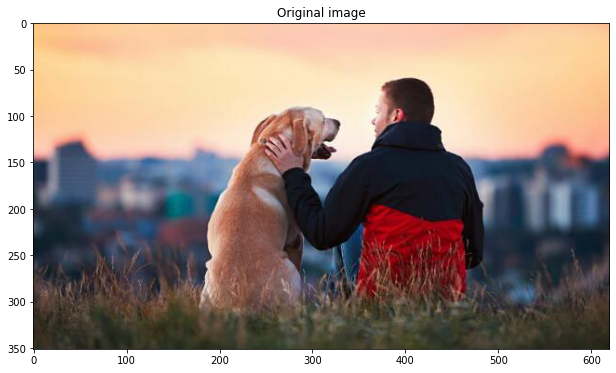

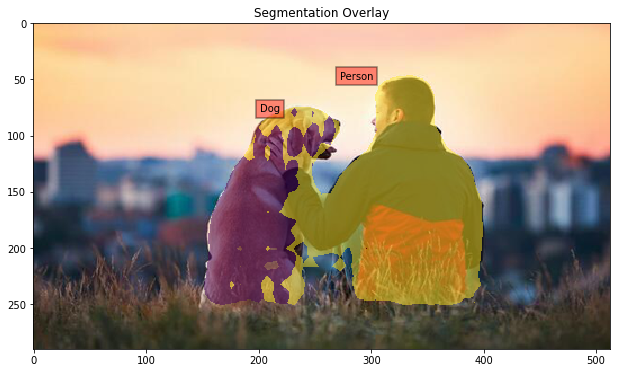

In [9]:

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
# IMAGE_URL = 'http://lesflaneriesdaurelie.com/wp-content/uploads/2018/11/jaffa7.jpg' #@param {type:"string"}
IMAGE_URL = 'https://content.active.com/Assets/Active.com+Content+Site+Digital+Assets/Article+Image+Update/2017/Dec+12/Man+Sitting+With+His+Dog-Carousel.jpg'

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  # --------- Original --------- # 
  fig = plt.figure(figsize=(13, 6)) 
  plt.imshow( original_im )
  plt.title('Original image')
  # --------- Segmented -------- #
  resized_im, seg_map = MODEL.run(original_im)
  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)
